# TRAINING MODELS
*This is a notebook about ML models*

## SETUP

In [3]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# To make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "chapter4_models"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [37]:
# Extra modules imported during the work
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

## LINEAR REGRESSION

### The Normal Equation 
*The direct “closed-form” equation*

Saving figure generated_data_plot


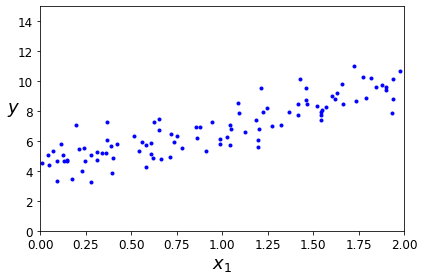

In [5]:
# Generate linear-looking data
X = 2 * np.random.rand(100, 1)
y = 4 + 3 * X + np.random.randn(100, 1)

# Plot data
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([0, 2, 0, 15])
save_fig("generated_data_plot")
plt.show()

In [6]:
# Best fit directly using Normal Equation
X_b = np.c_[np.ones((100, 1)), X] # add x0=1 to each instance
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y) # parameter vector
theta_best

array([[4.21509616],
       [2.77011339]])

**Evaluate:** $\theta_{0}=4$ and $\theta_{1}=3$ but the noise makes it impossible to recover the exact parameters.

In [7]:
# Make prediction using the "trained" model
X_new = np.array([[0], [2]]) # Create two arbitrary records
X_new_b = np.c_[np.ones((2, 1)), X_new] # add x0=1 to each instance
y_predict = X_new_b.dot(theta_best)
y_predict

array([[4.21509616],
       [9.75532293]])

Saving figure linear_model_predictions_plot


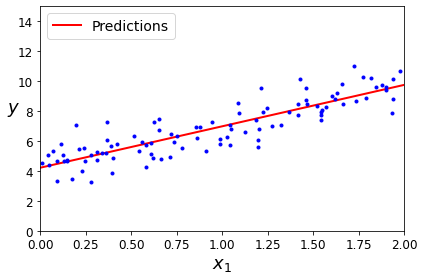

In [8]:
# Plot the model's predictions
plt.plot(X_new, y_predict, "r-", linewidth=2, label="Predictions")
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
plt.axis([0, 2, 0, 15])
save_fig("linear_model_predictions_plot")
plt.show()

In [9]:
# Sklearn implementation of linear regression - normal equation
lin_reg = LinearRegression()
lin_reg.fit(X, y)
lin_reg.intercept_, lin_reg.coef_

(array([4.21509616]), array([[2.77011339]]))

In [10]:
lin_reg.predict(X_new)

array([[4.21509616],
       [9.75532293]])

**Remark:** `LinearRegression` class is based on the `scipy.linalg.lstsq()` function, which can be called directly.

In [11]:
# Directly call linalg.lstsq
theta_best_svd, residuals, rank, s = np.linalg.lstsq(X_b, y, rcond=1e6)
theta_best_svd

array([[4.21509616],
       [2.77011339]])

**Remark:** This function computes $X^{+}y$, where $X^{+}$ is the *pseudoinverse* of $X$ *(the Moore-Penrose inverse)* 

In [12]:
# Compute parameter vector through pseudoinverse
np.linalg.pinv(X_b).dot(y)

array([[4.21509616],
       [2.77011339]])

**Evaluate:** Normal Equation may not work if the matrix $X^{T}X$ is not singular but pseudoinverse is always defined.

**Remark:** The pseudoinverse itself is computed using a standard matrix factorization technique called *Singular Value Decomposition (SVD)*.
- The computational complexity of Normal Equation is $O(n^{3})$
- The computational complexity of SVD approach is $O(n^{2})$

=> Both get very slow when the number of features grows large (e.g., 100,000)

However, prediction using Normal Equation is fast since computattional complexity is linear.

### Gradient Descent
*The iterative approach*

#### Batch Gradient Descent
*Use the whole batch of training data at every step*

In [13]:
# Batch gradient descent
eta = 0.1 # learing rate
n_iterations = 1000
m = 100

theta = np.random.randn(2,1) # random initialization of theta value

for iteration in range(n_iterations):
    gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
    theta = theta - eta * gradients

theta

array([[4.21509616],
       [2.77011339]])

In [14]:
# Setup to plot the first 10 steps of Gradient Descent
theta_path_bgd = []

def plot_gradient_descent(theta, eta, theta_path=None):
    m = len(X_b)
    plt.plot(X, y, "b.")
    n_iterations = 1000
    for iteration in range(n_iterations):
        if iteration < 10:
            y_predict = X_new_b.dot(theta)
            style = "b-" if iteration > 0 else "r--"
            plt.plot(X_new, y_predict, style)
        gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
        theta = theta - eta * gradients
        if theta_path is not None:
            theta_path.append(theta)
    plt.xlabel("$x_1$", fontsize=18)
    plt.axis([0, 2, 0, 15])
    plt.title(r"$\eta = {}$".format(eta), fontsize=16)

Saving figure gradient_descent_plot


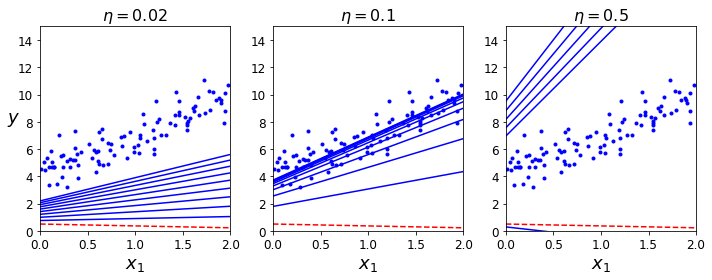

In [15]:
# Plot the first 10 steps of Gradient Descent with 3 different learing rates
np.random.seed(42)
theta = np.random.randn(2,1)  # random initialization

plt.figure(figsize=(10,4))
plt.subplot(131); plot_gradient_descent(theta, eta=0.02)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(132); plot_gradient_descent(theta, eta=0.1, theta_path=theta_path_bgd)
plt.subplot(133); plot_gradient_descent(theta, eta=0.5)

save_fig("gradient_descent_plot")
plt.show()

**Evaluate:**
- LHS: Learning rate is too low, which makes the convergence be slow
- RHS: Learning rate is too high, which makes the algorithm diverge
- Mid: Good learning rate

#### Stochastic Gradient Descent
*Picks a random instance in the training set at every step*

In [16]:
# Stochastic Gradient Descent implemeted using a simple learning schedule
n_epochs = 50
t0, t1 = 5, 50 # learning schedule hyperparameters

def learning_schedule(t):
    return t0 / (t + t1)

theta = np.random.randn(2,1) # random initialization of theta value

for epoch in range(n_epochs):
    for i in range(m):
        random_index = np.random.randint(m)
        xi = X_b[random_index:random_index + 1]
        yi = y[random_index:random_index + 1]
        gradients = 2 * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(epoch * m + i)
        theta = theta - eta * gradients

theta

array([[4.20742938],
       [2.74264448]])

Saving figure sgd_plot


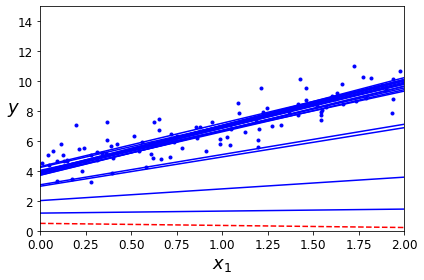

In [17]:
# Plot the first 20 steps of training
np.random.seed(42)
theta_path_sgd = []

n_epochs = 50
t0, t1 = 5, 50  # learning schedule hyperparameters

def learning_schedule(t):
    return t0 / (t + t1)

theta = np.random.randn(2,1)  # random initialization

for epoch in range(n_epochs):
    for i in range(m):
        if epoch == 0 and i < 20:                    
            y_predict = X_new_b.dot(theta)           
            style = "b-" if i > 0 else "r--"         
            plt.plot(X_new, y_predict, style)        
        random_index = np.random.randint(m)
        xi = X_b[random_index:random_index+1]
        yi = y[random_index:random_index+1]
        gradients = 2 * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(epoch * m + i)
        theta = theta - eta * gradients
        theta_path_sgd.append(theta)                

plt.plot(X, y, "b.")                                 
plt.xlabel("$x_1$", fontsize=18)                     
plt.ylabel("$y$", rotation=0, fontsize=18)           
plt.axis([0, 2, 0, 15])                              
save_fig("sgd_plot")                                 
plt.show()

In [18]:
# Sklearn implementation for SGD
sgd_reg = SGDRegressor(max_iter=1000, tol=1e-3, penalty=None, eta0=0.1, random_state=42)
sgd_reg.fit(X, y.ravel())
sgd_reg.intercept_, sgd_reg.coef_

(array([4.24365286]), array([2.8250878]))

#### Mini-batch Gradient Descent
*Pick small random sets of instances called mini-batches*

In [19]:
# Mini-batch Gradient Descent using a simple learning schedule
theta_path_mgd = []

n_iterations = 50
t0, t1 = 200, 1000 # learning schedule hyperparameters
minibatch_size = 20

theta = np.random.randn(2,1)  # random initialization

def learning_schedule(t):
    return t0 / (t + t1)

t = 0
for epoch in range(n_iterations):
    shuffled_indices = np.random.permutation(m)
    X_b_shuffled = X_b[shuffled_indices]
    y_shuffled = y[shuffled_indices]
    for i in range(0, m, minibatch_size):
        t += 1
        xi = X_b_shuffled[i:i+minibatch_size]
        yi = y_shuffled[i:i+minibatch_size]
        gradients = 2/minibatch_size * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(t)
        theta = theta - eta * gradients
        theta_path_mgd.append(theta)

theta

array([[4.19841898],
       [2.7659822 ]])

Saving figure gradient_descent_paths_plot


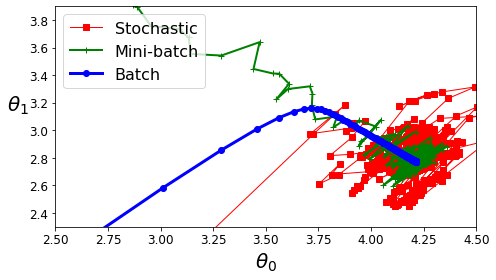

In [20]:
# Plot the Gradient Descents' paths in parameter space
np.random.seed(42)
theta_path_bgd = np.array(theta_path_bgd)
theta_path_sgd = np.array(theta_path_sgd)
theta_path_mgd = np.array(theta_path_mgd)

plt.figure(figsize=(7,4))
plt.plot(theta_path_sgd[:, 0], theta_path_sgd[:, 1], "r-s", linewidth=1, label="Stochastic")
plt.plot(theta_path_mgd[:, 0], theta_path_mgd[:, 1], "g-+", linewidth=2, label="Mini-batch")
plt.plot(theta_path_bgd[:, 0], theta_path_bgd[:, 1], "b-o", linewidth=3, label="Batch")
plt.legend(loc="upper left", fontsize=16)
plt.xlabel(r"$\theta_0$", fontsize=20)
plt.ylabel(r"$\theta_1$   ", fontsize=20, rotation=0)
plt.axis([2.5, 4.5, 2.3, 3.9])
save_fig("gradient_descent_paths_plot")
plt.show()

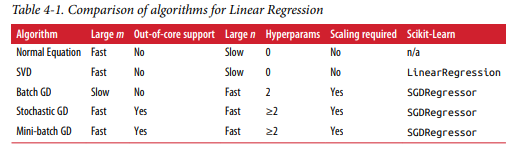

## Polynomial Regression

In [21]:
# Generate a simple quadratic equation
np.random.seed(42)
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X**2 + X + 2 + np.random.randn(m, 1)

Saving figure quadratic_data_plot


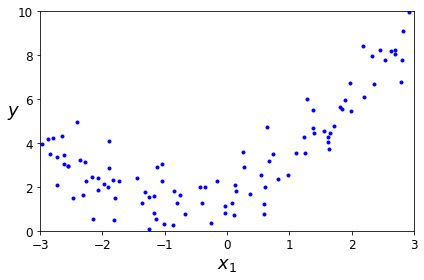

In [22]:
# Plot the data
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([-3, 3, 0, 10])
save_fig("quadratic_data_plot")
plt.show()

In [23]:
# Sklearn implementation for 2nd-degree polynomial
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)
X[0]

array([-0.75275929])

In [24]:
X_poly[0]

array([-0.75275929,  0.56664654])

**Remark:** `X_poly` now contains the original feature of X plus the square of this feature, which means we can fit a `LinearRegression`.

In [25]:
# Polynomial regression as Linear regression
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_

(array([1.78134581]), array([[0.93366893, 0.56456263]]))

Saving figure quadratic_predictions_plot


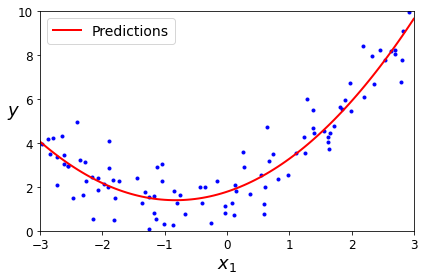

In [26]:
# Plot the 'linear' model
X_new=np.linspace(-3, 3, 100).reshape(100, 1)
X_new_poly = poly_features.transform(X_new)
y_new = lin_reg.predict(X_new_poly)
plt.plot(X, y, "b.")
plt.plot(X_new, y_new, "r-", linewidth=2, label="Predictions")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
plt.axis([-3, 3, 0, 10])
save_fig("quadratic_predictions_plot")
plt.show()

**Remark:** Beware the combinatorial explosion of the number of features!

## Learning Curves

Saving figure high_degree_polynomials_plot


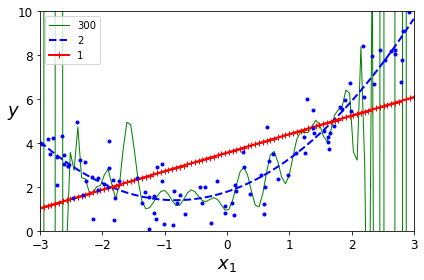

In [27]:
# Plot the high-degree polynomial regression vs other models
for style, width, degree in (("g-", 1, 300), ("b--", 2, 2), ("r-+", 2, 1)):
    polybig_features = PolynomialFeatures(degree=degree, include_bias=False)
    std_scaler = StandardScaler()
    lin_reg = LinearRegression()
    polynomial_regression = Pipeline([
            ("poly_features", polybig_features),
            ("std_scaler", std_scaler),
            ("lin_reg", lin_reg),
        ])
    polynomial_regression.fit(X, y)
    y_newbig = polynomial_regression.predict(X_new)
    plt.plot(X_new, y_newbig, style, label=str(degree), linewidth=width)

plt.plot(X, y, "b.", linewidth=3)
plt.legend(loc="upper left")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([-3, 3, 0, 10])
save_fig("high_degree_polynomials_plot")
plt.show()

**Evaluate:**
- High-degree Polynomial Regression model is severely overfitting
- Linear Regression is underfitting

In [28]:
# Setup to plot learning curve
def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=10)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train) + 1):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))

    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
    plt.legend(loc="upper right", fontsize=14)   
    plt.xlabel("Training set size", fontsize=14) 
    plt.ylabel("RMSE", fontsize=14)

Saving figure underfitting_learning_curves_plot


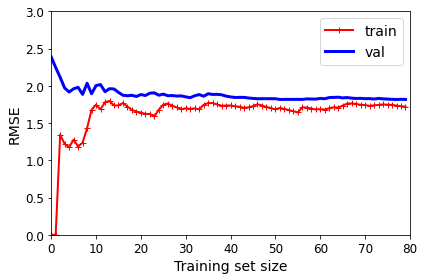

In [29]:
# Plot learning curve of Linear Regression
lin_reg = LinearRegression()
plot_learning_curves(lin_reg, X, y)
plt.axis([0, 80, 0, 3])                        
save_fig("underfitting_learning_curves_plot")   
plt.show()

**Evaluate:** This learning curve is typical of an underfitting model. Both curves have reached a plateau; they are close and fairly high.

Saving figure learning_curves_plot


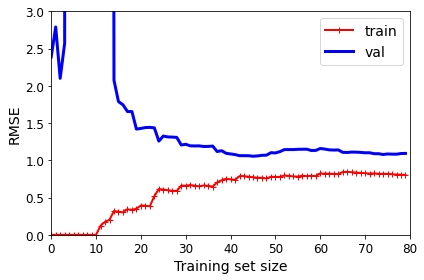

In [30]:
# Plot learning curve of a 10th-degree polynomial model
polynomial_regression = Pipeline([
        ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
        ("lin_reg", LinearRegression()),
    ])

plot_learning_curves(polynomial_regression, X, y)
plt.axis([0, 80, 0, 3])           # not shown
save_fig("learning_curves_plot")  # not shown
plt.show()  

**Evaluate:**
- The error on the training data is much lower than with the Linear Regression model.
- A gap between 2 curves, the model performs significantly better on the training data than on the validation data (Overfit)

## Regularized Linear Models
*Reduce overfitting*

### Ridge Regression
*$l_{2}$ norm of the weight vector*

**Remark:** As with Linear Regression, we can perform Ridge Regression either by computing a **closed-form equation** or by performing **Gradient Descent**
- Closed-form: $(X^{T}X + \alpha A)^{-1} X^{T} y$ with $A$ is an identity matrix.
- Gradient descent: Add $\alpha w$ to the MSE gradient vector, with $w$ is the weight vector.

In [31]:
# Generate data
np.random.seed(42)

m = 20
X = 3 * np.random.rand(m, 1)
y = 1 + 0.5 * X + np.random.randn(m, 1) / 1.5
X_new = np.linspace(0, 3, 100).reshape(100, 1)

In [32]:
# Ridge regression
ridge_reg = Ridge(alpha=1, solver="cholesky", random_state=42)
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[1.55071465]])

Saving figure ridge_regression_plot


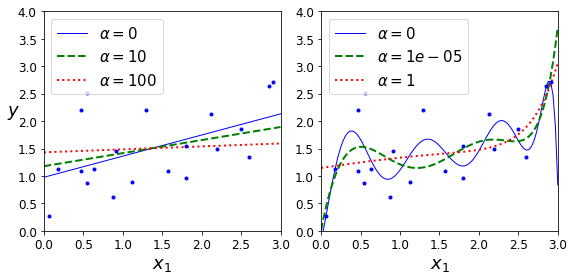

In [33]:
# Plot Ridge regression with different alpha
def plot_model(model_class, polynomial, alphas, **model_kargs):
    for alpha, style in zip(alphas, ("b-", "g--", "r:")):
        model = model_class(alpha, **model_kargs) if alpha > 0 else LinearRegression()
        if polynomial:
            model = Pipeline([
                    ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
                    ("std_scaler", StandardScaler()),
                    ("regul_reg", model),
                ])
        model.fit(X, y)
        y_new_regul = model.predict(X_new)
        lw = 2 if alpha > 0 else 1
        plt.plot(X_new, y_new_regul, style, linewidth=lw, label=r"$\alpha = {}$".format(alpha))
    plt.plot(X, y, "b.", linewidth=3)
    plt.legend(loc="upper left", fontsize=15)
    plt.xlabel("$x_1$", fontsize=18)
    plt.axis([0, 3, 0, 4])

plt.figure(figsize=(8,4))
plt.subplot(121)
plot_model(Ridge, polynomial=False, alphas=(0, 10, 100), random_state=42)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(122)
plot_model(Ridge, polynomial=True, alphas=(0, 10**-5, 1), random_state=42)

save_fig("ridge_regression_plot")
plt.show()

### Lasso Regression
*$l_{1}$ norm of the weight vector*

E:\IDE\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.802867703827439, tolerance: 0.0009294783355207351
  model = cd_fast.enet_coordinate_descent(


Saving figure lasso_regression_plot


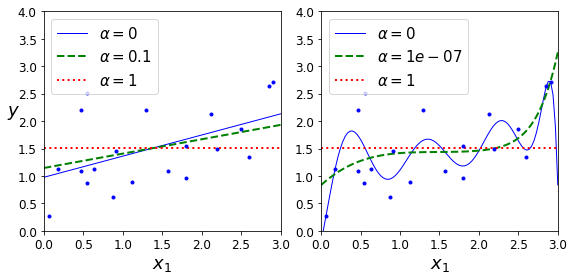

In [35]:
# Plot Lasso Regression for linear and polynomial model
plt.figure(figsize=(8,4))
plt.subplot(121)
plot_model(Lasso, polynomial=False, alphas=(0, 0.1, 1), random_state=42)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(122)
plot_model(Lasso, polynomial=True, alphas=(0, 10**-7, 1), random_state=42)

save_fig("lasso_regression_plot")
plt.show()

In [36]:
# Lasso Regression
lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X, y)
lasso_reg.predict([[1.5]])

array([1.53788174])

### Elastic Net
*Lasso + Ridge*

In [38]:
# Elastic Net
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42) # l1_ratio is the mix ratio r
elastic_net.fit(X, y)
elastic_net.predict([[1.5]])

array([1.54333232])